# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Optimize-with-Tucson-Unified-District-data" data-toc-modified-id="Optimize-with-Tucson-Unified-District-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Optimize with Tucson Unified District data</a></div><div class="lev1 toc-item"><a href="#Get-$\hat\beta$" data-toc-modified-id="Get-$\hat\beta$-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get <span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-5-Frame" tabindex="0" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>&amp;#x03B2;</mi><mo stretchy=&quot;false&quot;>&amp;#x005E;</mo></mover></mrow></math>" role="presentation" style="position: relative;"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-21" role="math" style="width: 0.643em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.514em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.188em 1000.51em 2.502em -999.998em); top: -2.21em; left: 0.002em;"><span class="mrow" id="MathJax-Span-22"><span class="texatom" id="MathJax-Span-23"><span class="mrow" id="MathJax-Span-24"><span class="munderover" id="MathJax-Span-25"><span style="display: inline-block; position: relative; width: 0.514em; height: 0px;"><span style="position: absolute; clip: rect(3.239em 1000.51em 4.296em -999.998em); top: -4.005em; left: 0.002em;"><span class="mi" id="MathJax-Span-26" style="font-family: STIXMathJax_Main-italic;">β<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.002em;"></span></span><span style="display: inline-block; width: 0px; height: 4.008em;"></span></span><span style="position: absolute; top: -4.261em; left: 0.13em;"><span style="height: 0.002em; vertical-align: 0.002em; width: 0.386em; display: inline-block; overflow: hidden;"></span><span class="mo" id="MathJax-Span-27" style="font-family: STIXMathJax_Main;">̂&nbsp;<span style="height: 0.002em; vertical-align: 0.002em; margin-left: -0.255em;"></span></span><span style="display: inline-block; overflow: hidden; height: 1px; width: 0.002em;"></span><span style="display: inline-block; width: 0px; height: 4.008em;"></span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.213em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.267em; border-left: 0px solid; width: 0px; height: 1.425em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>β</mi><mo stretchy="false">^</mo></mover></mrow></math></span></span><script type="math/tex" id="MathJax-Element-5">\hat\beta</script></a></div>

Possibly the reason we aren't getting a significant treatment effect so far is that we don't have enough data. After all, the credible band of the treatment effect cliff face is quite large. Let's see if we can pull in more data.

In [1]:
using LaTeXStrings
using GaussianProcesses
using GaussianProcesses: grad_slice!, cov!, addcov!, KernelData
import GaussianProcesses: get_params, set_params!, num_params
import GaussianProcesses: distance, optimize!
import GaussianProcesses: Mean, Kernel, grad_stack!, grad_stack
import PDMats: AbstractPDMat, PDMat
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
using DataFrames
using GeoJSON
using Optim
using GLM
import MultivariateStats
mvst=MultivariateStats
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [2]:
Tucson_sales=readtable("Tucson_data/processed/Tucson_sales.csv", header=true)
# categorical variables
pool!(Tucson_sales, [
    :PropertyType, 
    :SchDistr, 
    :Financing, 
    :ValidationDescription, 
    :BuyerSellerRelated, 
    :Solar,
    :PersonalProperty, 
    :PartialInterest,
    :HEAT,
    :COOL,
    :QUALITY,
    :CLASS,
    :WALLS,
    :ROOF,
    :GARAGE,
    ])
believable = zeros(Bool, size(Tucson_sales,1))
for i in 1:size(Tucson_sales,1)
    if isna(Tucson_sales[i,:BuyerSellerRelated])
        continue
    end
    if Tucson_sales[i,:BuyerSellerRelated]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PartialInterest])
        continue
    end
    if Tucson_sales[i,:PartialInterest]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PropertyType])
        continue
    end
    if !(Tucson_sales[i,:PropertyType] in ("2-4 Plex", "Condo/Townhouse", "Single Family"))
        continue
    end
    if isna(Tucson_sales[i,:ValidationDescription])
        continue
    end
    if !(Tucson_sales[i,:ValidationDescription] in ("Good Sale", "Buyer/Seller has an Out-Of-State Address"))
        continue
    end
    if isna(Tucson_sales[i,:SQFT])
        continue
    end
    believable[i] = true
end
sum(believable)

22203

In [3]:
# GP_dict=Dict{String, GP}()
σf = 0.2
σy = 0.2
L = 1300.0
_kern = SEIso(log(L), log(σf))
_logNoise = log(σy)

-1.6094379124341003

In [4]:
Tucson_sales[:logSalePrice] = log(Tucson_sales[:SalePrice]);
nobsv_ = sum(believable)
for_mm = copy(Tucson_sales[believable,:])
for_mm[:SQFT] =  for_mm[:SQFT] .- mean(for_mm[:SQFT])
for_mm[:SQFT] = for_mm[:SQFT] ./ std(for_mm[:SQFT])
for_mm[:ROOMS] = for_mm[:ROOMS] .- mean(for_mm[:ROOMS])
for_mm[:ROOMS] = for_mm[:ROOMS] ./ std(for_mm[:ROOMS])
for_mm[:STORIES] = for_mm[:STORIES] .- mean(for_mm[:STORIES])
for_mm[:STORIES] = for_mm[:STORIES] ./ std(for_mm[:STORIES])
reordering = collect(1:nobsv_)
schdistrs = unique(for_mm[:,:SchDistr])
istart = 1
for name in schdistrs
    indices = find(for_mm[:SchDistr] .== name)
    nobsv_schdistr = length(indices)
    iend = istart+nobsv_schdistr-1
    reordering[istart:iend,:] = indices
    istart = iend+1
end
for_mm = for_mm[reordering,:]
schdistr_indices = Dict{String,Vector{Int}}()
for name in schdistrs
    indices = find(for_mm[:SchDistr] .== name)
    schdistr_indices[name] = indices
end
;

In [5]:
Y_dict=Dict{String, Vector{Float64}}()
X_dict=Dict{String, Array{Float64,2}}()
for name in schdistrs
    Y_dict[name] = for_mm[schdistr_indices[name], :logSalePrice]
    X_dict[name] = for_mm[schdistr_indices[name],[:X_PRJ, :Y_PRJ]]
end
sentinels_json=GeoJSON.parsefile("Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json")
sentinels=Dict{Tuple{String,String},GeoJSON.MultiPoint}()
for f in sentinels_json.features
    key = (f.properties["SchoolDistrict1"], f.properties["SchoolDistrict2"])
    sentinels[key] = f.geometry
end

In [6]:
contrasts_dict = Dict()
for (term,col) in eachcol(for_mm)
    DataFrames.is_categorical(col) || continue
    contrasts_dict[term] = DataFrames.FullDummyCoding()
end
mf=DataFrames.ModelFrame(logSalePrice ~ SQFT + QUALITY + STORIES + CLASS + ROOF + GARAGE, 
    for_mm, 
    contrasts=contrasts_dict)
mm=ModelMatrix(mf)
p = size(mm,2)
D_=mm.m;

In [7]:
σβ = 1.0
βkern_ = GaussianProcesses.LinIso(log(σβ))
type GPCovars   
    m:: Mean                # Mean object
    k::Kernel               # Kernel object
    βkern::Kernel
    logNoise::Float64       # log standard deviation of observation noise
    
    # Observation data
    nobsv::Int              # Number of observations
    X::Matrix{Float64}      # Input observations
    y::Vector{Float64}      # Output observations
    D::Array{Float64,2}
    data::KernelData        # Auxiliary observation data (to speed up calculations)
    βdata::KernelData
    p::Int                  # Dimensions of covariates
    dim::Int                # Dimension of inputs
    
    # Auxiliary data
    cK::AbstractPDMat       # (k + exp(2*obsNoise))
    alpha::Vector{Float64}  # (k + exp(2*obsNoise))⁻¹y
    mLL::Float64            # Marginal log-likelihood
    dmLL::Vector{Float64}   # Gradient marginal log-likelihood

    function GPCovars(X::Matrix{Float64}, 
        y::Vector{Float64}, 
        D::Matrix{Float64},
        m::Mean, 
        k::Kernel,
        βkern::Kernel,
        logNoise::Float64=-1e8,
        )
        dim, nobsv = size(X)
        p, nobsv2 = size(D)
        nobsv == nobsv2 || throw(ArgumentError("X and D should have the same number of rows"))
        length(y) == nobsv || throw(ArgumentError("X and y should have the same number of rows"))
        gp = new(m, k, βkern, logNoise, nobsv, X, y, D, KernelData(k, X), KernelData(βkern, D), p, dim)
        update_mll!(gp)
        return gp
    end
end

In [8]:
function update_mll!(gp::GPCovars, cK::Matrix{Float64})
    μ = mean(gp.m, gp.X)
    cov!(cK, gp.βkern, gp.D, gp.βdata)
    addcov!(cK, gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        cK[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    gp.cK = PDMat(cK)
    gp.alpha = gp.cK \ (gp.y .- μ)
    gp.mLL = -dot((gp.y-μ),gp.alpha)/2.0 - logdet(gp.cK)/2.0 - gp.nobsv*log(2π)/2.0
end
function update_mll!(gp::GPCovars)
    Σbuffer = Array(Float64, gp.nobsv, gp.nobsv)
    update_mll!(gp, Σbuffer)
end
function update_mll!!(gp::GPCovars)
    cK = gp.cK.mat
    μ = mean(gp.m, gp.X)
    cov!(cK, gp.βkern, gp.D, gp.βdata)
    addcov!(cK, gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        cK[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    chol_buffer = gp.cK.chol.factors
    copy!(chol_buffer, cK)
    chol = cholfact!(Symmetric(chol_buffer))
    gp.cK = PDMats.PDMat(cK, chol)
    gp.alpha = gp.cK \ (gp.y - μ)
    gp.mLL = -dot((gp.y - μ),gp.alpha)/2.0 - logdet(gp.cK)/2.0 - gp.nobsv*log(2π)/2.0 # Marginal log-likelihood
end
function get_ααinvcKI!(ααinvcKI::Matrix, cK::AbstractPDMat, α::Vector)
    nobsv = length(α)
    size(ααinvcKI) == (nobsv, nobsv) || throw(ArgumentError, 
                @sprintf("Buffer for ααinvcKI should be a %dx%d matrix, not %dx%d",
                         nobsv, nobsv,
                         size(ααinvcKI,1), size(ααinvcKI,2)))
    ααinvcKI[:,:] = 0.0
    @inbounds for i in 1:nobsv
        ααinvcKI[i,i] = -1.0
    end
    A_ldiv_B!(cK.chol, ααinvcKI)
    LinAlg.BLAS.ger!(1.0, α, α, ααinvcKI)
end
""" Update gradient of marginal log-likelihood """
function update_mll_and_dmll!(gp::GPCovars,
    Kgrad::Matrix{Float64},
    ααinvcKI::Matrix{Float64}
    ; 
    noise::Bool=true, # include gradient component for the logNoise term
    mean::Bool=true, # include gradient components for the mean parameters
    kern::Bool=true, # include gradient components for the spatial kernel parameters
    beta::Bool=true, # include gradient components for the linear regression prior terms
    )
    update_mll!!(gp)
    n_mean_params = num_params(gp.m)
    n_kern_params = num_params(gp.k)
    n_beta_params = num_params(gp.βkern)
    gp.dmLL = Array(Float64, noise + mean*n_mean_params + kern*n_kern_params + beta*n_beta_params)
    logNoise = gp.logNoise
    get_ααinvcKI!(ααinvcKI, gp.cK, gp.alpha)
    i=1
    if noise
        gp.dmLL[i] = exp(2.0*logNoise)*trace(ααinvcKI)
        i+=1
    end
    if mean
        Mgrads = grad_stack(gp.m, gp.X)
        for j in 1:n_mean_params
            gp.dmLL[i] = dot(Mgrads[:,j],gp.alpha)
            i += 1
        end
    end
    if kern
        for iparam in 1:n_kern_params
            grad_slice!(Kgrad, gp.k, gp.X, gp.data, iparam)
            gp.dmLL[i] = dot(Kgrad,ααinvcKI)/2.0
            i+=1
        end
    end
    if beta
        for iparam in 1:n_beta_params
            grad_slice!(Kgrad, gp.βkern, gp.D, gp.βdata, iparam)
            gp.dmLL[i] = vecdot(ααinvcKI,Kgrad)/2.0
            i+=1
        end
    end
end
function set_params!(gp::GPCovars, hyp::Vector{Float64}; 
                    noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    i=1
    if noise
        gp.logNoise = hyp[i]
        i+=1
    end
    if mean
        set_params!(gp.m, hyp[i:i+num_params(gp.m)-1])
        i+=num_params(gp.m)
    end
    if kern
        set_params!(gp.k, hyp[i:i+num_params(gp.k)-1])
        i+=num_params(gp.k)
    end
    if beta
        set_params!(gp.βkern, hyp[i:i+num_params(gp.βkern)-1])
        i+=num_params(gp.βkern)
    end
end
function get_params(gp::GPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    params = Float64[]
    if noise; push!(params, gp.logNoise); end
    if mean;  append!(params, get_params(gp.m)); end
    if kern; append!(params,  get_params(gp.k)); end
    if beta; append!(params,  get_params(gp.βkern)); end
    return params
end
function optimize!(gp::GPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true, 
                    method=ConjugateGradient(), kwargs...)
    Kgrad_buffer = Array(Float64, gp.nobsv, gp.nobsv)
    ααinvcKI = Array(Float64, gp.nobsv, gp.nobsv)
    function mll(hyp::Vector{Float64})
        try
            set_params!(gp, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
            update_mll!!(gp)
            return -gp.mLL
        catch err
             if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end        
    end

    function mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        try
            set_params!(gp, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
            update_mll_and_dmll!(gp, Kgrad_buffer, ααinvcKI; noise=noise, mean=mean, kern=kern, beta=beta)
            grad[:] = -gp.dmLL
            return -gp.mLL
        catch err
             if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end 
    end
    function dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
    end

    func = DifferentiableFunction(mll, dmll!, mll_and_dmll!)
    init = get_params(gp;  noise=noise, mean=mean, kern=kern, beta=beta)  # Initial hyperparameter values
    results=optimize(func,init; method=method, kwargs...)                     # Run optimizer
    set_params!(gp, results.minimum; noise=noise, mean=mean, kern=kern, beta=beta)
    return results
end

optimize! (generic function with 2 methods)

# Optimize with Tucson Unified District data

In [9]:
district="Tucson Unified District" # biggest district
_X = X_dict[district]'
_Y = Y_dict[district]
_Dd = D_[schdistr_indices[district],:]'
_m = MeanConst(mean(_Y))
@time gp=GPCovars(_X, _Y, _Dd, _m, _kern, βkern_, _logNoise)
;

 51.746304 seconds (889.99 k allocations: 8.346 GB, 0.86% gc time)


In [10]:
opt_out=optimize!(gp, iterations=10, x_tol=1e-4, f_tol=1e-3)

New linesearch
bracketing: ia = 1, ib = 2, c = 0.2, phic = 695542.00690069, dphic = 3.535363280171486e6
linesearch: ia = 1, ib = 2, a = 0.0, b = 0.2, phi(a) = -1805.4839765846718, phi(b) = 695542.00690069
secant2: a = 0.0, b = 0.2, c = 0.0034200653892626004
update: ia = 1, a = 0.0, ib = 2, b = 0.2, c = 0.0034200653892626004, phic = 3617.5110434291946, dphic = 2.617907639525667e6
secant2: iA = 1, iB = 3, ic = 3
secant2 output: a = 0.0, b = 0.0034200653892626004
Linesearch: secant succeeded
linesearch: ia = 1, ib = 3, a = 0.0, b = 0.0034200653892626004, phi(a) = -1805.4839765846718, phi(b) = 3617.5110434291946
secant2: a = 0.0, b = 0.0034200653892626004, c = 7.850975919302234e-5
update: ia = 1, a = 0.0, ib = 3, b = 0.0034200653892626004, c = 7.850975919302234e-5, phic = -1805.8327375585923, dphic = 52003.34094524186
secant2: iA = 1, iB = 4, ic = 4
secant2: second c = 1.0786244791437146e-5
secant2: second c satisfied Wolfe conditions


Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-1.6094379124341003,11.877910238410173, ...]
 * Minimizer: [-1.607154344929064,11.877909375471097, ...]
 * Minimum: -1.806062e+03
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 1.0e-04: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-03: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 7
 * Gradient Calls: 6

In [11]:
print(opt_out.minimum)

[-1.60715,11.8779,7.17003,-1.60807,0.000226718]

In [12]:
@printf("σ_y: %.4f\n", exp(gp.logNoise))
@printf("σ_f: %.4f\n", √(gp.k.σ2))
@printf("σ_β: %.4f\n", 1/√gp.βkern.ℓ2)
@printf("ℓ: %.4f\n", √(gp.k.ℓ2))

σ_y: 0.2005
σ_f: 0.2003
σ_β: 0.9998
ℓ: 1299.8823


# Get $\hat\beta$

In [13]:
function get_ΣYβ!(gp::GPCovars)
    Σ = cov(gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        Σ[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    return PDMats.PDMat(Σ)
end

get_ΣYβ! (generic function with 1 method)

In [14]:
ΣY_β = get_ΣYβ!(gp);

In [15]:
size(ΣY_β)

(16699,16699)

In [16]:
tmp = PDMats.X_invA_Xt(ΣY_β, gp.D)
for i in 1:p
    tmp[i,i] += gp.βkern.ℓ2
end
m = mean(gp.m,gp.X)
βhat = (tmp \ gp.D) * (ΣY_β \ (gp.y.-m))
βhat_dict=Dict(zip(coefnames(mf), βhat))

Dict{String,Float64} with 26 entries:
  "ROOF: Built Up" => -0.0223088
  "CLASS: R-4" => 0.332244
  "ROOF: Metal" => 0.125972
  "CLASS: R-6" => -0.638279
  "CLASS: R-2" => -0.0986411
  "CLASS: R-1" => -0.24749
  "ROOF: Other" => 0.00488082
  "ROOF: Tile" => -0.0208194
  "ROOF: Wood" => -0.0500832
  "QUALITY: Good" => -0.0104337
  "ROOF: Prepared Roll" => -0.0144044
  "GARAGE: Garage" => 0.0289281
  "QUALITY: Excellent" => 0.147704
  "ROOF: Asphalt" => -0.0322813
  "GARAGE: None" => -0.0764253
  "STORIES" => -0.095638
  "GARAGE: Carport" => -0.0439685
  "QUALITY: Minimum" => -0.141827
  "(Intercept)" => -0.0799811
  "CLASS: R-5" => 0.423718
  "CLASS: R-3" => 0.148468
  "ROOF: Slate" => -0.0476959
  "SQFT" => 0.20021
  "QUALITY: Fair" => -0.075424
  "ROOF: Asbestos" => -0.0232407
  "GARAGE: Garage & Carport (both)" => 0.0114846

In [17]:
resid = log(for_mm[:SalePrice]) - D_*βhat
resid_dict=Dict{String, Vector{Float64}}()
for name in schdistrs
    resid_dict[name] = resid[schdistr_indices[name]]
end

In [18]:
resid_GP_dict=Dict{String, GP}()
for name in schdistrs
    X = X_dict[name]
    if size(X,1)==0
        continue
    end
    Y = resid_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), gp.k, gp.logNoise)
    resid_GP_dict[name] = fit
end

In [19]:
GaussianProcesses.get_param_names(gp.k)

2-element Array{Symbol,1}:
 :ll
 :lσ

In [20]:
# for name in schdistrs
#     gp = resid_GP_dict[name]
#     GaussianProcesses.set_params!(gp.k, get_params(gp.k))
#     GaussianProcesses.update_mll!!(gp)
# end

In [21]:
distrA = "Amphitheater Unified District"
distrB = "Tucson Unified District"
X◫ = hcat(sentinels[distrA,distrB].coordinates...)
n◫ = size(X◫, 2)
resid_pred_A = GaussianProcesses.predict(resid_GP_dict[distrA], X◫; full_cov=true)
resid_pred_B = GaussianProcesses.predict(resid_GP_dict[distrB], X◫; full_cov=true)
resid_μposterior = resid_pred_A[1].-resid_pred_B[1]
resid_Σposterior = resid_pred_A[2]+resid_pred_B[2]
;

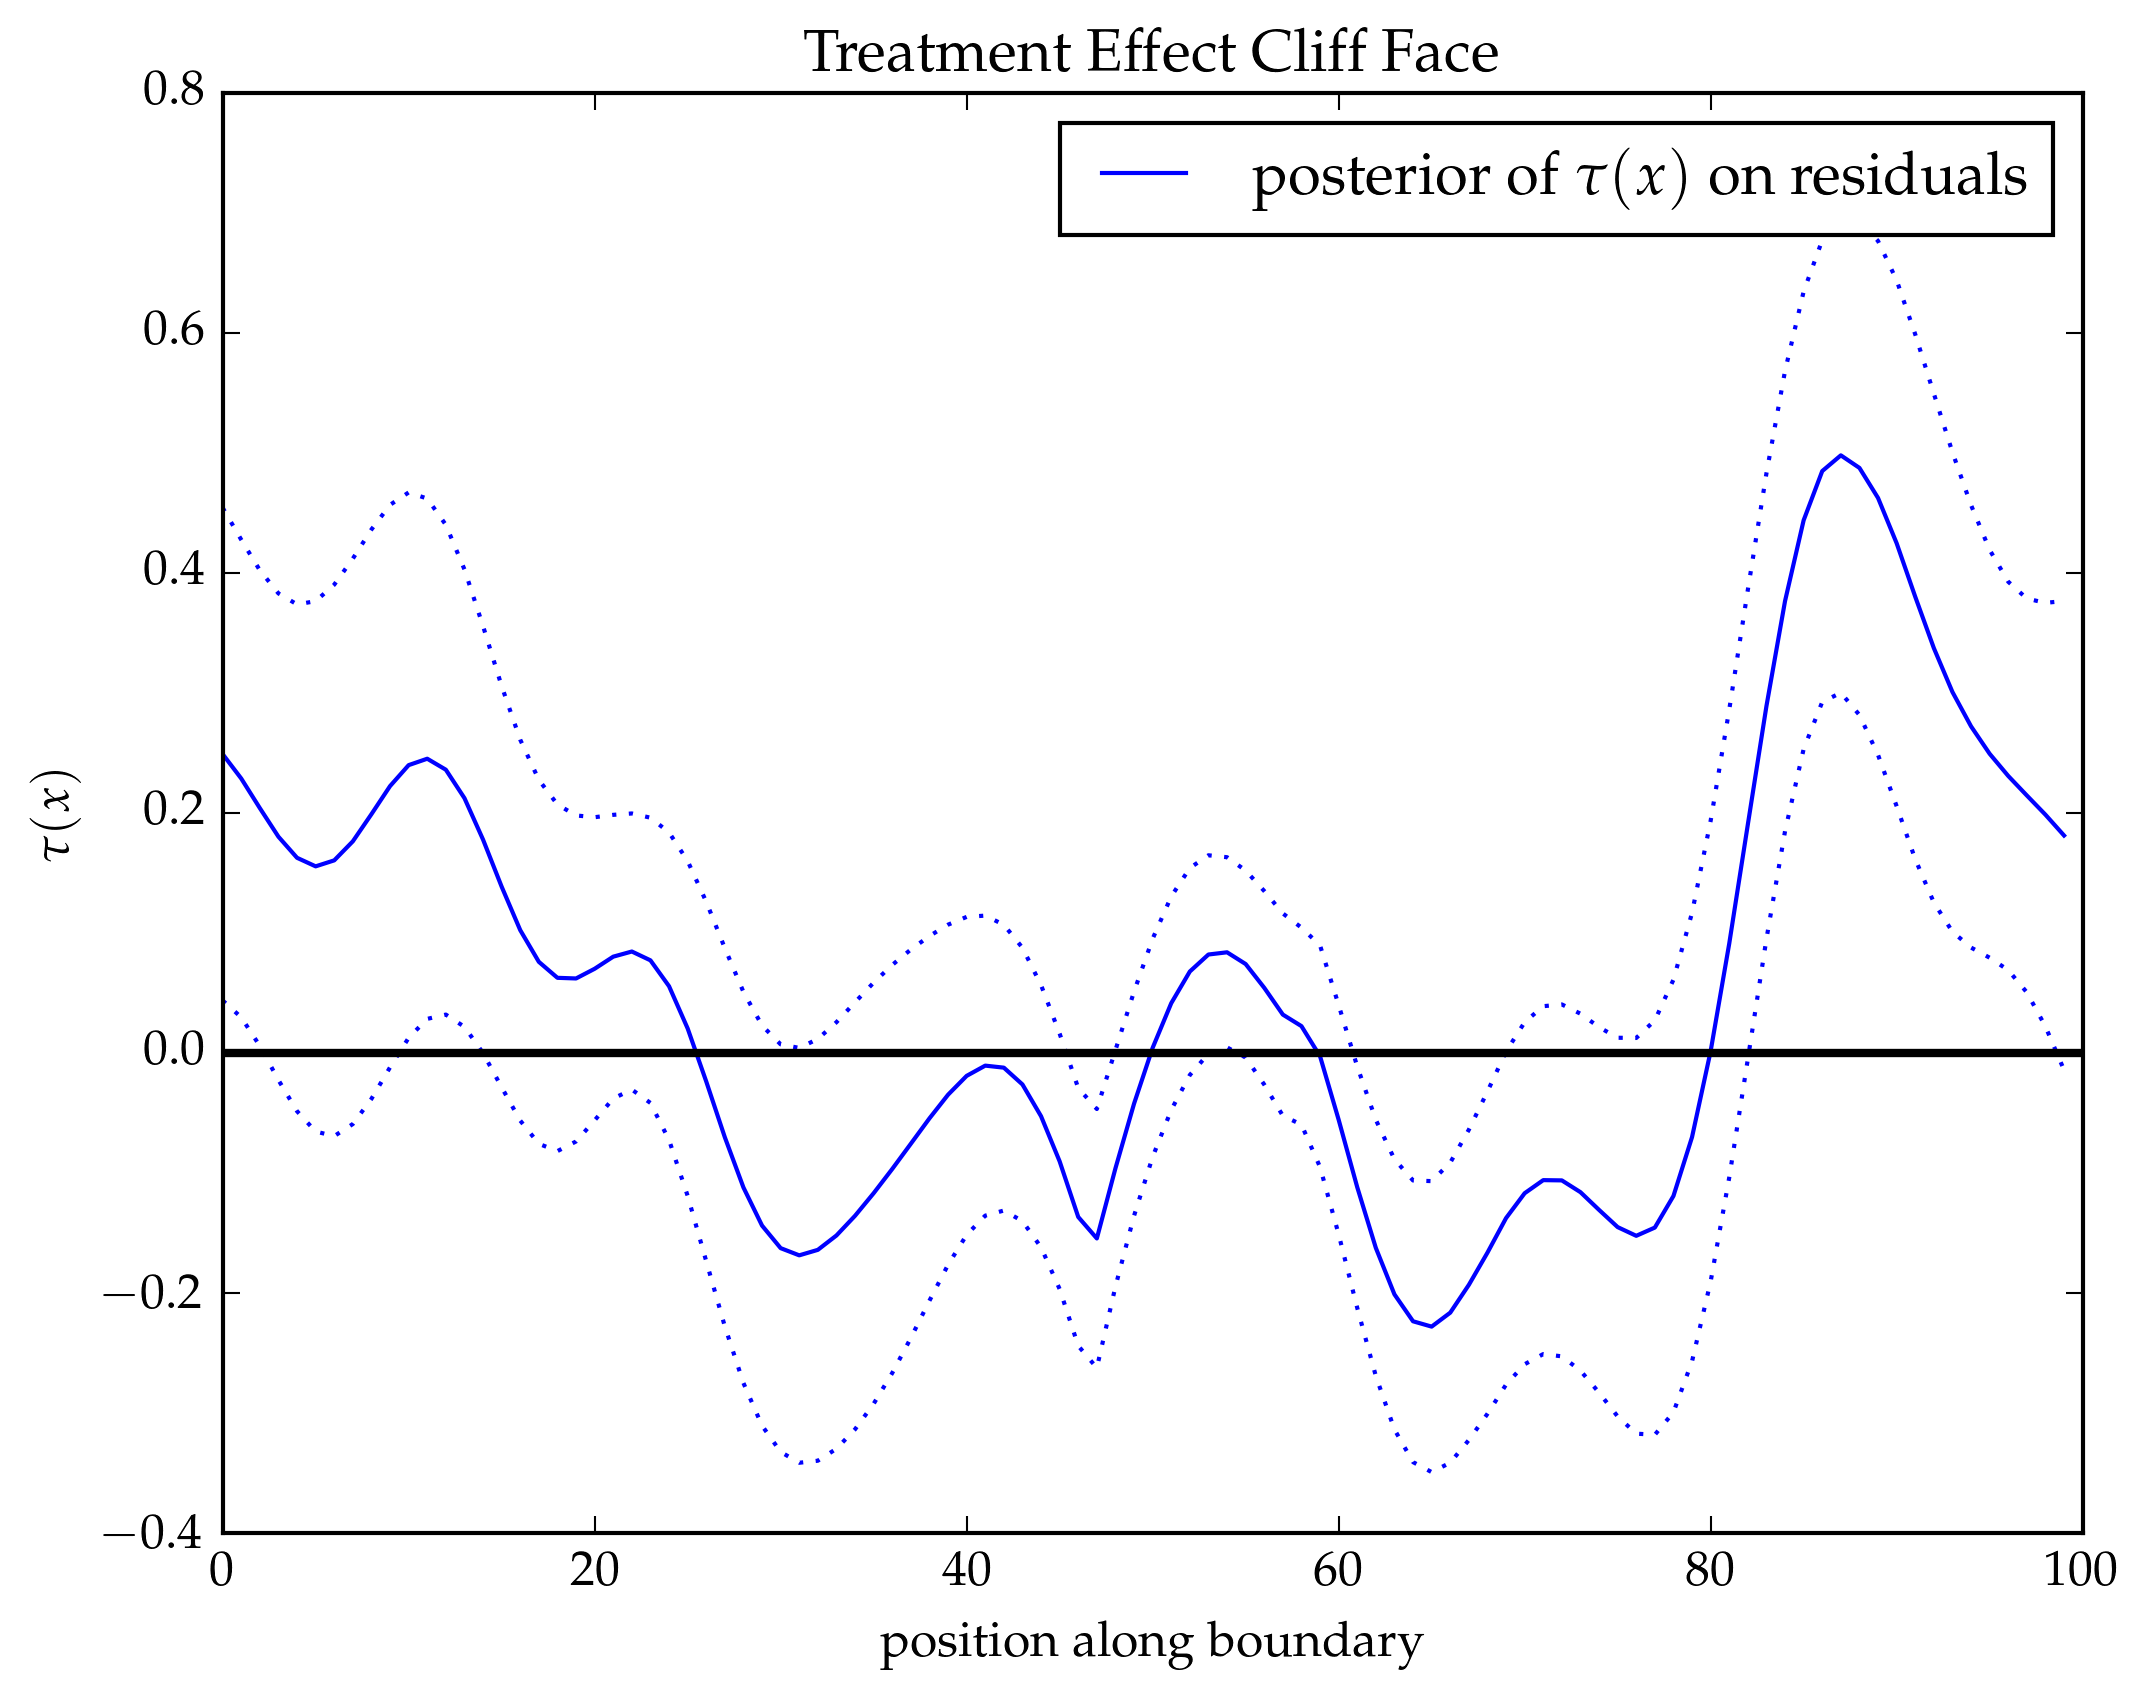

In [22]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(resid_μposterior, color="blue", label=L"posterior of $\tau(x)$ on residuals")
plt.plot(resid_μposterior.+√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(resid_μposterior.-√diag(resid_Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;